In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [4]:
def read_bmp(filepath):
    """
    Wczytuje obraz BMP i zwraca jako macierz RGB typu uint8.
    """
    image = Image.open(filepath)
    return np.array(image, dtype=np.uint8)

def show_image(image, title=''):
    """
    Wyświetla obraz RGB typu np.array
    """
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def save_array_to_bmp(array, filepath):
    """
    Zapisuje macierz RGB jako plik BMP
    """
    Image.fromarray(array).save(filepath)

In [5]:
def to_grayscale(img):
    return np.mean(img, axis=2).astype(np.uint8)

def binarize(img, x_factor=1.2):
     """
     Binaryzuje obraz na podstawie progu wyznaczonego jako:
     P = suma(jasności) / liczba pikseli
     Próg końcowy = P / x_factor  
     """
     h, w = img.shape
     P = np.sum(img) / (h * w)
     threshold = P / x_factor
     binary = (img > threshold).astype(np.uint8) * 255
     return binary.astype(np.uint8)   
    

In [ ]:
def delete_unimportant_objects_from_image(binary_img):
    """
    Zostawia tylko największy obiekt (źrenicę) na obrazie binarnym.
    Zakłada, że obraz ma wartości 0 i 255.
    """
    
    inverted_img = cv2.bitwise_not(binary_img)
    
    contours, _ = cv2.findContours(inverted_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        print("Brak konturów.")
        return binary_img

    largest_contour = max(contours, key=cv2.contourArea)

    # Nowa largest_object_imga tylko dla największego obiektu
    largest_object_img = np.zeros_like(inverted_img)
    cv2.drawContours(largest_object_img, [largest_contour], -1, color=255, thickness=-1)
    
    largest_object_img = cv2.bitwise_not(largest_object_img)

    return largest_object_img

def extract_pupil(binary_image):
    """
    Oczyszcza binarny obraz źrenicy z szumów i zakłóceń, zostawia tylko źrenicę.
    """
    kernel_large = np.ones((5, 5), np.uint8)
    kernel_small = np.ones((3, 3), np.uint8)

    extracted_image = binary_image.copy()

    extracted_image = delete_unimportant_objects_from_image(extracted_image)

    extracted_image = cv2.morphologyEx(extracted_image, cv2.MORPH_CLOSE, kernel_large)
    extracted_image = cv2.erode(extracted_image, kernel_small, iterations=2)
    
    extracted_image = cv2.dilate(extracted_image, kernel_small, iterations=2)
    extracted_image = cv2.medianBlur(extracted_image, 5)

    extracted_image = cv2.GaussianBlur(extracted_image, (9, 9), 0)
    extracted_image = cv2.morphologyEx(extracted_image, cv2.MORPH_OPEN, kernel_large)
    
    return extracted_image

def extract_iris(binary_image):
    """
    Oczyszcza binarny obraz tęczówki z szumów i zakłóceń, zostawia tylko tęczówkę (oczywiście ze źrenicą).
    """

    kernel_large = np.ones((5, 5), np.uint8)
    kernel_small = np.ones((3, 3), np.uint8)

    extracted_image = binary_image.copy()

    show_image(extracted_image, '1')
    extracted_image = cv2.morphologyEx(extracted_image, cv2.MORPH_CLOSE, kernel_large)
    show_image(extracted_image, '2')

    extracted_image = cv2.dilate(extracted_image, kernel_small, iterations=3)
    show_image(extracted_image, '3')

    extracted_image = cv2.erode(extracted_image, kernel_small, iterations=2)

    extracted_image = delete_unimportant_objects_from_image(extracted_image)
    show_image(extracted_image, '3....')


    extracted_image = cv2.GaussianBlur(extracted_image, (9, 9), 0)
    show_image(extracted_image, '4')

    extracted_image = cv2.medianBlur(extracted_image, 5)
    show_image(extracted_image, '5')
    extracted_image = cv2.morphologyEx(extracted_image, cv2.MORPH_OPEN, kernel_large)
    show_image(extracted_image, '6')
    
    return extracted_image

def do_projections(img, show_plots=True):
    """
    Oblicza projekcje poziomą i pionową obrazu.
    Wyświetla 2x2:
    - Lewy górny: obraz źrenicy
    - Prawy górny: projekcja pozioma (rzędy)
    - Lewy dolny: projekcja pionowa (kolumny, obrócona)
    - Prawy dolny: podpis
    """
    horizontal_projection = np.sum(img, axis=1)  # dla wierszy
    vertical_projection = np.sum(img, axis=0)    # dla kolumn

    if show_plots:
        fig = plt.figure(figsize=(12, 8))

        # Lewy górny – obraz źrenicy
        ax1 = plt.subplot2grid((2, 2), (0, 0))
        ax1.imshow(img, cmap='gray')
        ax1.set_title('Wyekstrahowana źrenica')
        ax1.axis('off')

        # Prawy górny – wykres poziomy (rzędy)
        ax2 = plt.subplot2grid((2, 2), (0, 1))
        ax2.plot(horizontal_projection, color='black')
        ax2.set_title('Projekcja pozioma')
        ax2.set_xlabel('Rząd (y)')
        ax2.set_ylabel('Suma jasności')
        ax2.grid(True)

        # Lewy dolny – wykres pionowy (kolumny), obrócony
        ax3 = plt.subplot2grid((2, 2), (1, 0))
        ax3.plot(np.arange(len(vertical_projection)), vertical_projection, color='black')
        ax3.set_title('Projekcja pionowa')
        ax3.set_xlabel('Kolumna (x)')
        ax3.set_ylabel('Suma jasności')
        ax3.grid(True)

        # Prawy dolny – podpis
        ax4 = plt.subplot2grid((2, 2), (1, 1))
        ax4.axis('off')
        ax4.text(0.5, 0.5, 'Projekcje źrenicy', ha='center', va='center', fontsize=12)

        plt.tight_layout()
        plt.show()

    return horizontal_projection, vertical_projection



def find_pupil_center_and_radius_from_projections(h_proj, v_proj, diff_threshold=0.3):
    """
    Znajduje środek i promień źrenicy na podstawie projekcji poziomej i pionowej.
    Ulepszona wersja bazująca na różnicach i medianie.
    """
    # Środek źrenicy = miejsce, gdzie projekcja ma minimum (najciemniej)
    y_candidates = np.where(h_proj == np.min(h_proj))[0]
    x_candidates = np.where(v_proj == np.min(v_proj))[0]

    y_center = int(np.median(y_candidates)) if len(y_candidates) > 0 else h_proj.shape[0] // 2
    x_center = int(np.median(x_candidates)) if len(x_candidates) > 0 else v_proj.shape[0] // 2

    # Różnice między sąsiednimi wartościami projekcji
    h_diff = np.abs(np.diff(h_proj.astype(np.int64)))
    v_diff = np.abs(np.diff(v_proj.astype(np.int64)))

    # Krawędzie źrenicy = miejsca, gdzie różnica przekracza próg
    h_edges = np.where(h_diff > np.max(h_diff) * diff_threshold)[0]
    v_edges = np.where(v_diff > np.max(v_diff) * diff_threshold)[0]

    if len(h_edges) >= 2:
        r_y = (h_edges[-1] - h_edges[0]) // 2
    else:
        r_y = 0

    if len(v_edges) >= 2:
        r_x = (v_edges[-1] - v_edges[0]) // 2
    else:
        r_x = 0

    # Promień: średnia z promienia w pionie i poziomie (ew. możesz użyć max(r_x, r_y))
    r = (r_x + r_y) // 2

    return (x_center, y_center, r)

def find_iris_center_and_radius_from_projections(h_proj, v_proj, d45_proj, d135_proj, diff_threshold=0.3):
    """
    Znajduje środek i promień tęczówki na podstawie klasycznych i ukośnych projekcji.
    """
    # Wyznacz środek z minimum (ciemnych pasów)
    y_center = int(np.median(np.where(h_proj == np.min(h_proj))[0]))
    x_center = int(np.median(np.where(v_proj == np.min(v_proj))[0]))
    
    # Promienie z różnic klasycznych
    h_diff = np.abs(np.diff(h_proj.astype(np.int64)))
    v_diff = np.abs(np.diff(v_proj.astype(np.int64)))
    d45_diff = np.abs(np.diff(d45_proj.astype(np.int64)))
    d135_diff = np.abs(np.diff(d135_proj.astype(np.int64)))

    h_edges = np.where(h_diff > np.max(h_diff) * diff_threshold)[0]
    v_edges = np.where(v_diff > np.max(v_diff) * diff_threshold)[0]
    d45_edges = np.where(d45_diff > np.max(d45_diff) * diff_threshold)[0]
    d135_edges = np.where(d135_diff > np.max(d135_diff) * diff_threshold)[0]

    r_h = (h_edges[-1] - h_edges[0]) // 2 if len(h_edges) >= 2 else 0
    r_v = (v_edges[-1] - v_edges[0]) // 2 if len(v_edges) >= 2 else 0
    r_45 = (d45_edges[-1] - d45_edges[0]) // 2 if len(d45_edges) >= 2 else 0
    r_135 = (d135_edges[-1] - d135_edges[0]) // 2 if len(d135_edges) >= 2 else 0

    # Średni promień (bardziej odporne na powiekę)
    r = int(np.mean([r_h, r_v, r_45, r_135]))

    return (x_center, y_center, r)


def do_iris_projections_diagonal(img, show_plots=True):
    """
    Oblicza projekcje po przekątnych (45° i 135°) dla obrazu binarnego.
    - Projekcja 45°: przekątna od lewej dolnej do prawej górnej
    - Projekcja 135°: przekątna od lewej górnej do prawej dolnej
    """
    h, w = img.shape
    img_int = img.astype(np.uint32)

    diag_45 = [np.sum(np.fliplr(img_int).diagonal(offset)) for offset in range(-h + 1, w)]
    diag_135 = [np.sum(img_int.diagonal(offset)) for offset in range(-h + 1, w)]

    if show_plots:
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        axs[0].plot(diag_45, color='black')
        axs[0].set_title('Projekcja 45° (↘)')
        axs[0].set_xlabel('Przekątna')
        axs[0].set_ylabel('Suma jasności')
        axs[0].grid(True)

        axs[1].plot(diag_135, color='black')
        axs[1].set_title('Projekcja 135° (↙)')
        axs[1].set_xlabel('Przekątna')
        axs[1].set_ylabel('Suma jasności')
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

    return np.array(diag_45), np.array(diag_135)

def draw_contour(image, x, y, r):
    """
    Rysuje kontur (okrąg) źrenicy na kopii obrazu.
    """
    if image.ndim == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    output = image.copy()
    cv2.circle(output, (x, y), r, (57, 255, 20), 1)
    return output


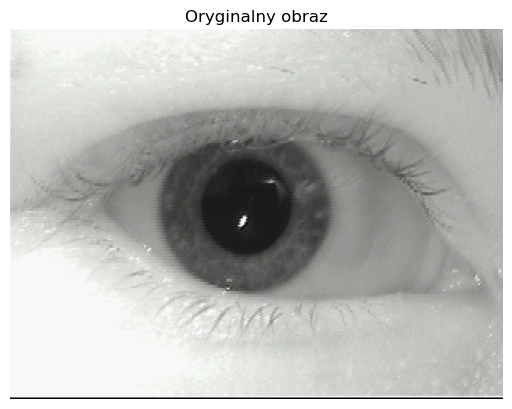

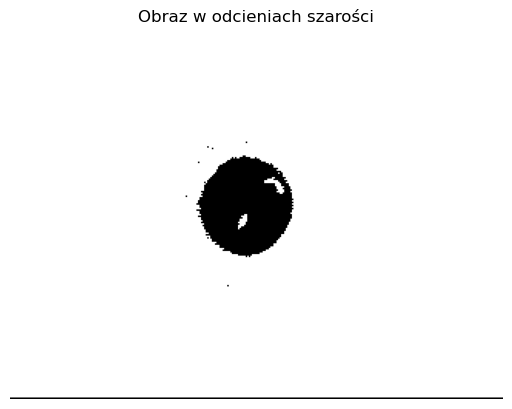

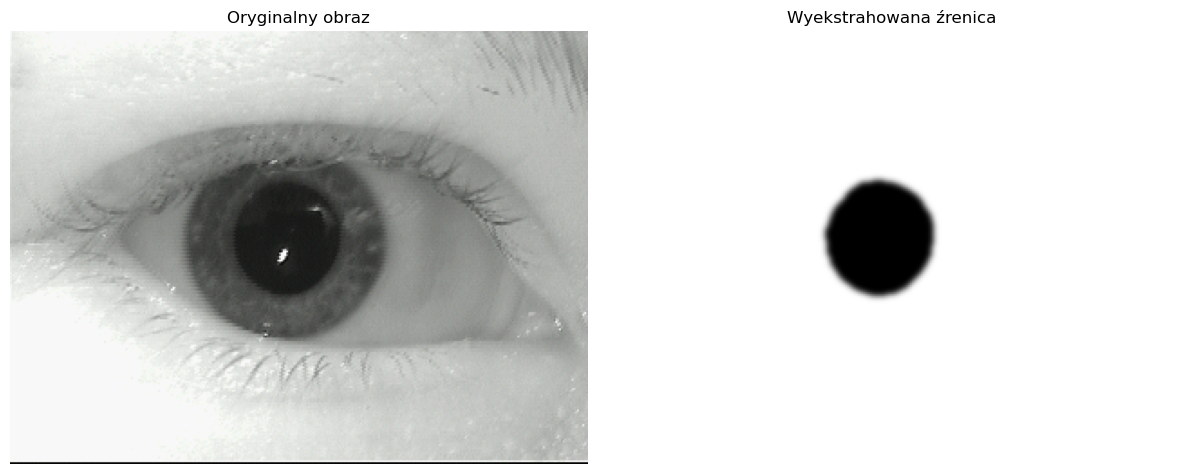

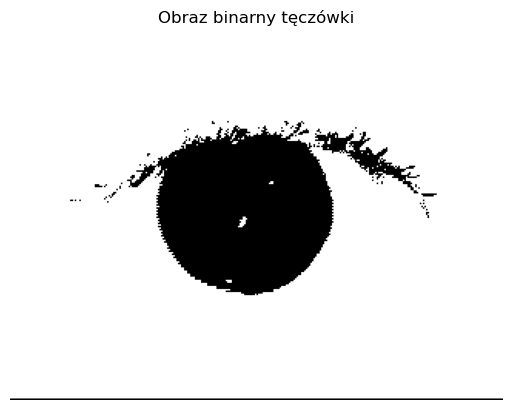

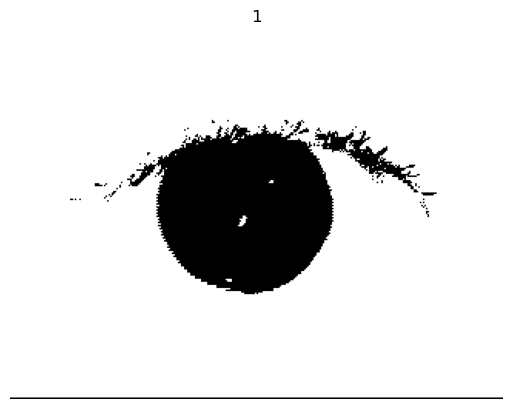

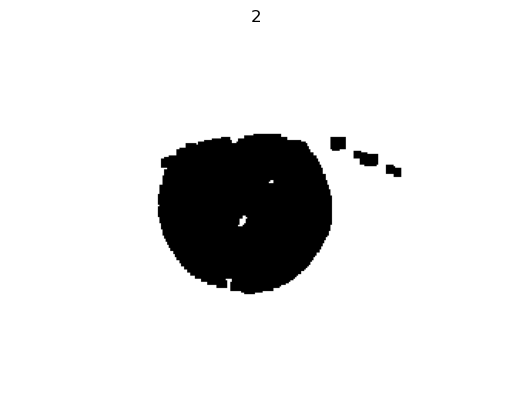

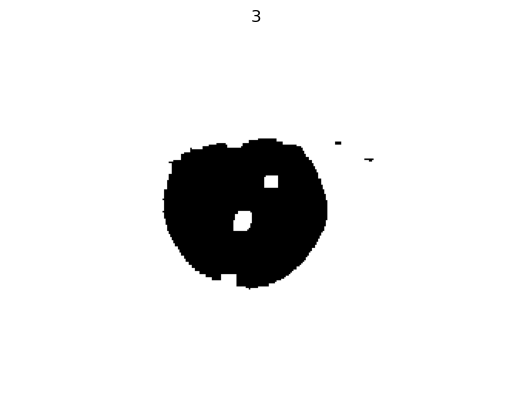

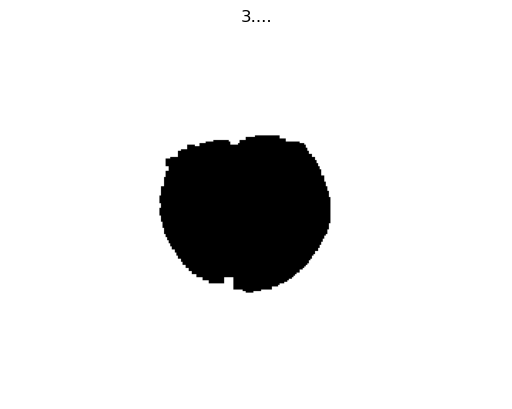

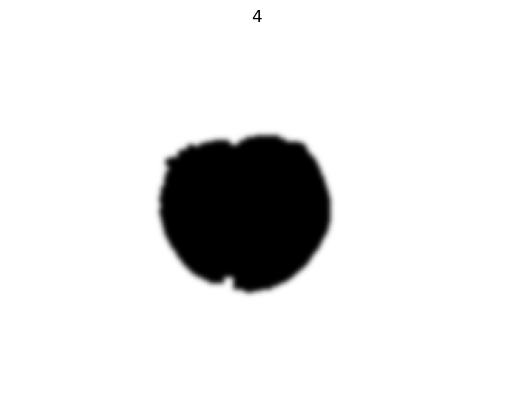

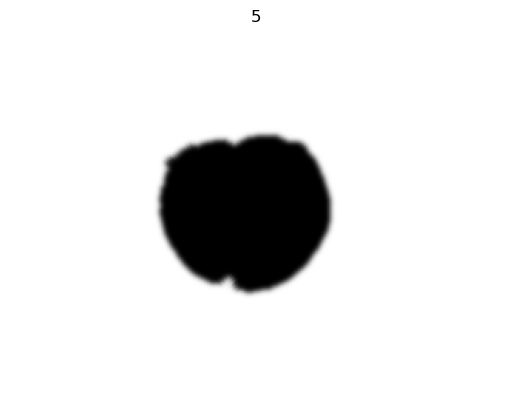

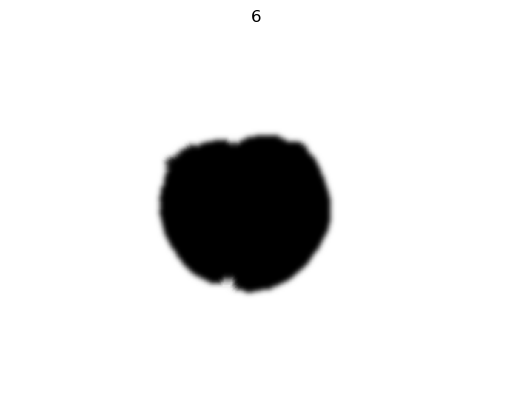

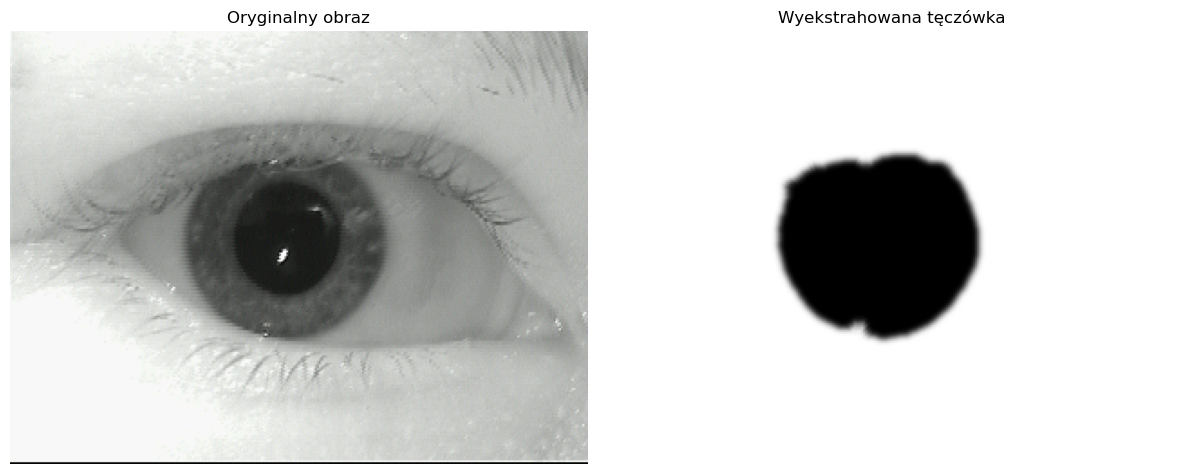

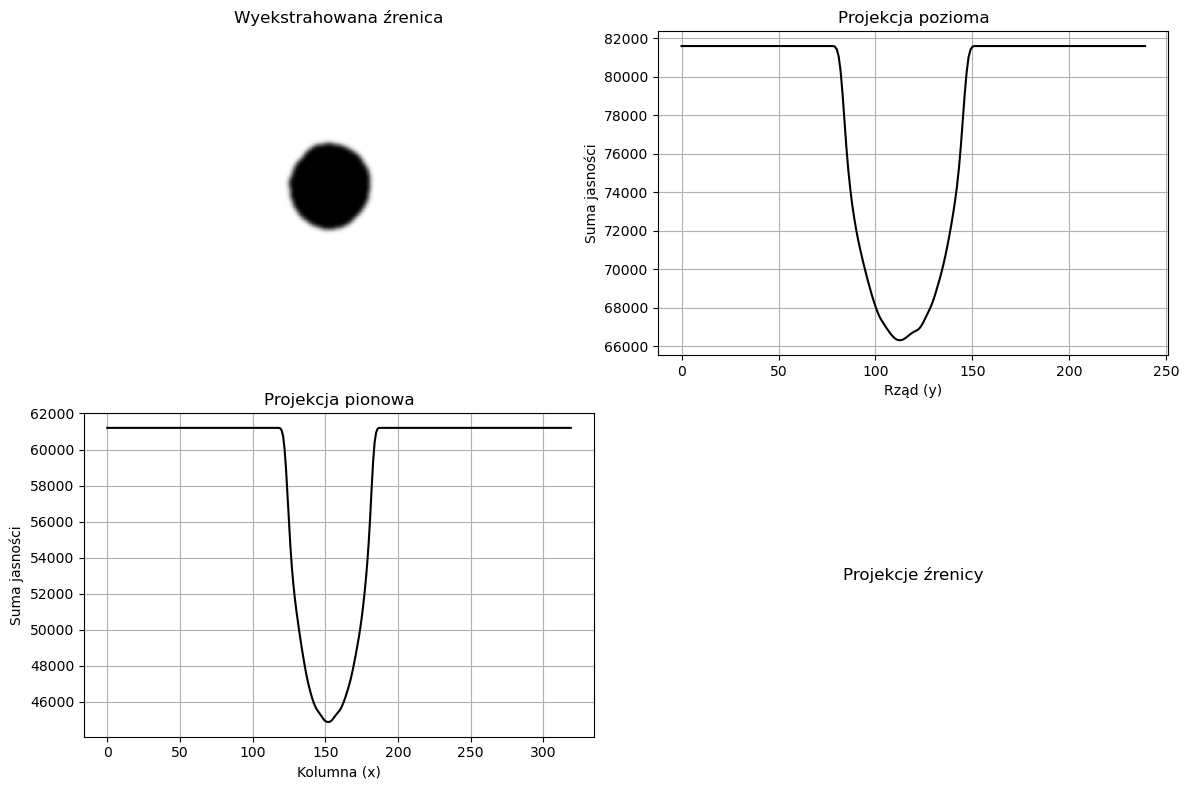

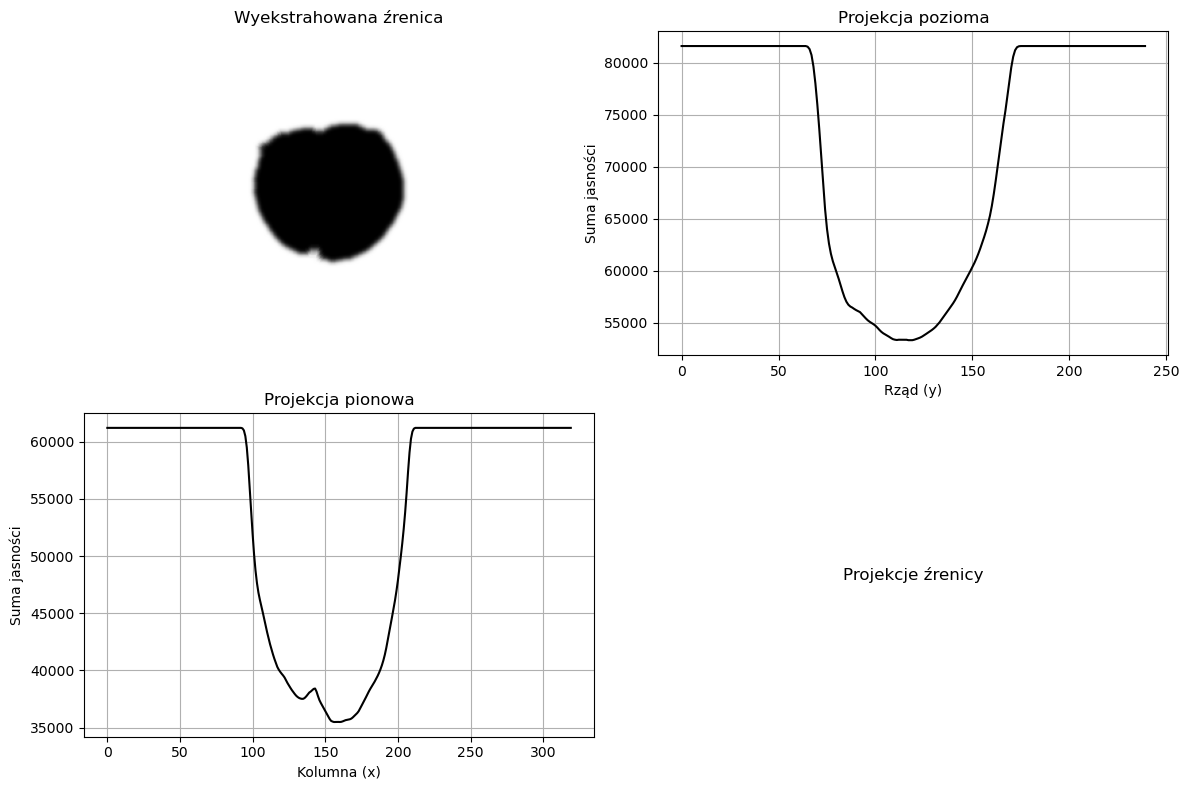

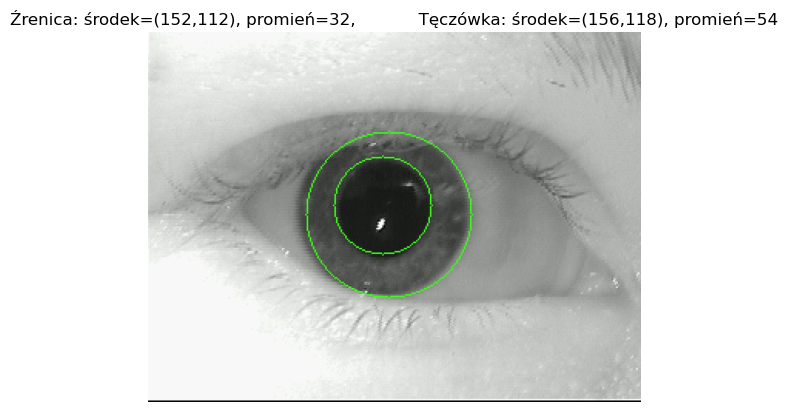

In [8]:
number = '10'
direction = 'right'
name = 'fionar3'

##### Wczytanie i wyświetlenie oryginalnego obrazu #####
original_img = read_bmp(f'./data/MMU-Iris-Database/{number}/{direction}/{name}.bmp')
show_image(original_img, 'Oryginalny obraz')


# ##### Przetwarzanie obrazu - konwersja do skali szarości i binaryzacja #####
img = to_grayscale(original_img)
img_binarized_pupil = binarize(img, x_factor=3.5)
show_image(img_binarized_pupil, 'Obraz w odcieniach szarości')

##### Usunięcie nieistotnych obiektów z obrazu binarnego i wyekstrahowanie źrenicy #####
img_pupil_extracted = extract_pupil(img_binarized_pupil)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(original_img)
axes[0].set_title('Oryginalny obraz')
axes[0].axis('off')

axes[1].imshow(img_pupil_extracted, cmap='gray')
axes[1].set_title('Wyekstrahowana źrenica')
axes[1].axis('off')

plt.tight_layout()
plt.show()

##### Wekstrahowanie tęczówki i źrenicy z obrazów #####

img_binarized_iris = binarize(img, x_factor=1.5)

show_image(img_binarized_iris, 'Obraz binarny tęczówki')

##### Usunięcie nieistotnych obiektów z obrazu binarnego i wyekstrahowanie tęczówki #####

img_iris_extracted = extract_iris(img_binarized_iris) ####### TUTAJ NIC SIE NIE DZIEJE JESZCZE

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(original_img)
axes[0].set_title('Oryginalny obraz')
axes[0].axis('off')

axes[1].imshow(img_iris_extracted, cmap='gray')
axes[1].set_title('Wyekstrahowana tęczówka')
axes[1].axis('off')

plt.tight_layout()
plt.show()


##### Projekcja pionowa i pozioma w celu znalezienia promienia źrenicy #####
h_proj_pupil, v_proj_pupil = do_projections(img_pupil_extracted, show_plots=True)
x_pupil, y_pupil, r_pupil = find_pupil_center_and_radius_from_projections(h_proj_pupil, v_proj_pupil)
h_proj_iris, v_proj_iris = do_projections(img_iris_extracted, show_plots=True)
x_iris, y_iris, r_iris = find_pupil_center_and_radius_from_projections(h_proj_iris, v_proj_iris)

# ##### Rysowanie konturu źrenicy na oryginalnym obrazie #####

contour_img = draw_contour(original_img, x_pupil, y_pupil, r_pupil)
contour_img = draw_contour(contour_img, x_iris, y_iris, r_iris)
show_image(contour_img, f'Źrenica: środek=({x_pupil},{y_pupil}), promień={r_pupil}, \
           Tęczówka: środek=({x_iris},{y_iris}), promień={r_iris}')


### Ponizej sobie eksperymentuje ekstrakcje teczowki

In [10]:
binary_image = binarize(img, x_factor=1.5)

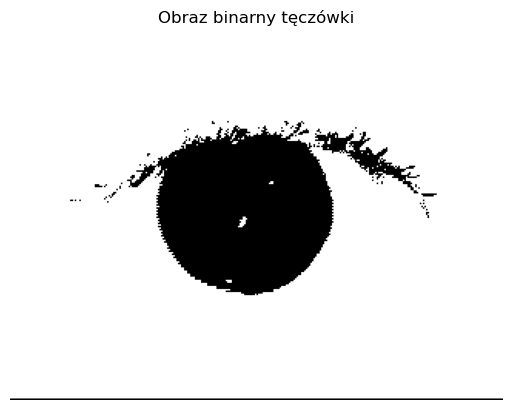

In [11]:
show_image(binary_image, 'Obraz binarny tęczówki')

### To co w poniższej komórce to de facto funkcja extract_iris (ja nie wiem, tutaj na wielu zdjeciach nie daje rady ale to doslownie zmienianie parametrow jak na MIOwAD mam wrażenie - na niektorych zdjeciach dziala)

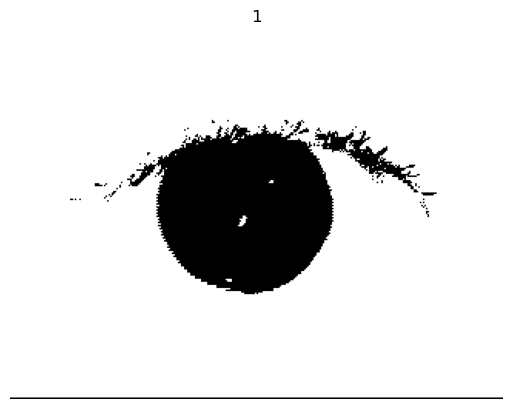

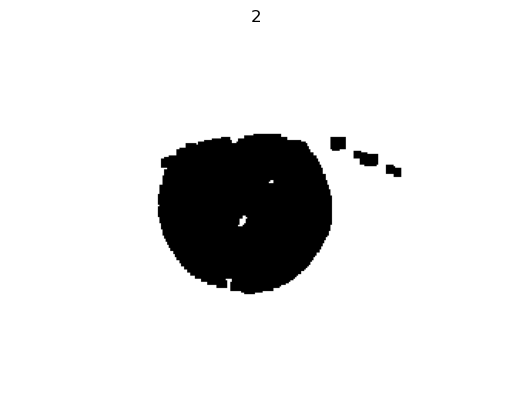

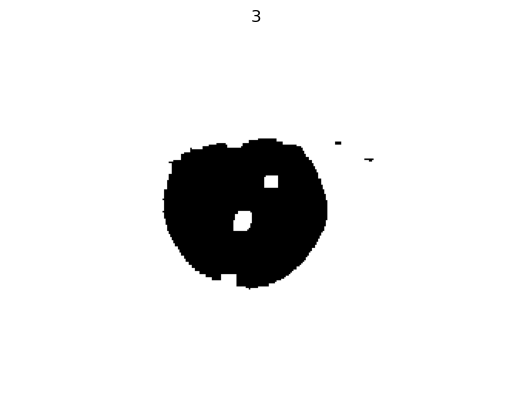

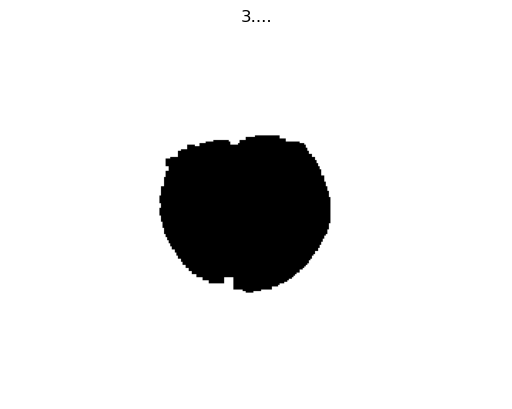

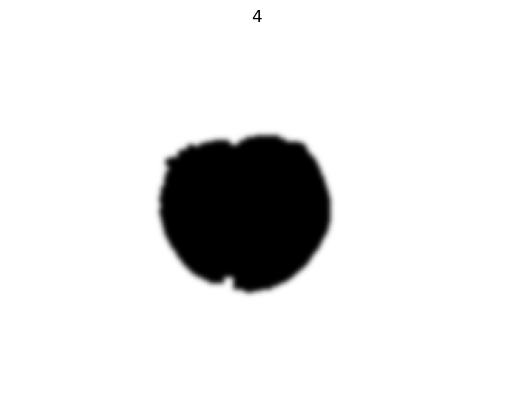

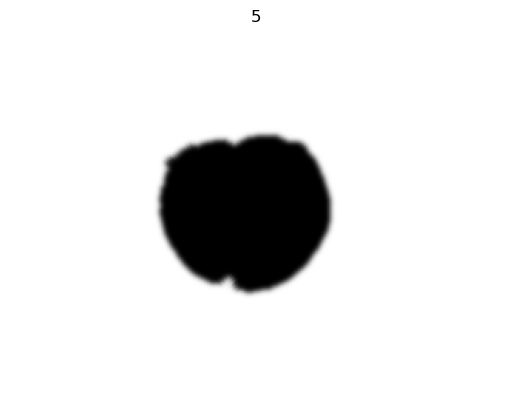

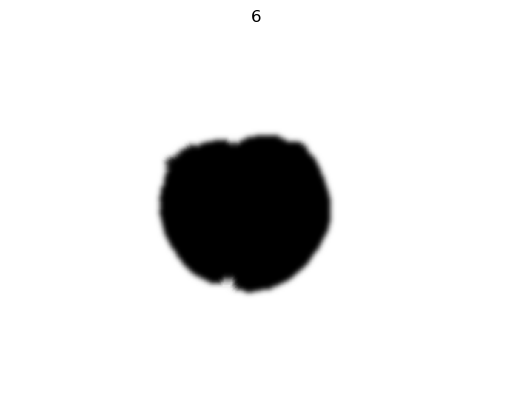

In [12]:


kernel_large = np.ones((5, 5), np.uint8)
kernel_small = np.ones((3, 3), np.uint8)

extracted_image = binary_image.copy()

show_image(extracted_image, '1')
extracted_image = cv2.morphologyEx(extracted_image, cv2.MORPH_CLOSE, kernel_large)
show_image(extracted_image, '2')

extracted_image = cv2.dilate(extracted_image, kernel_small, iterations=3)
show_image(extracted_image, '3')

extracted_image = cv2.erode(extracted_image, kernel_small, iterations=2)

extracted_image = delete_unimportant_objects_from_image(extracted_image)
show_image(extracted_image, '3....')


extracted_image = cv2.GaussianBlur(extracted_image, (9, 9), 0)
show_image(extracted_image, '4')

extracted_image = cv2.medianBlur(extracted_image, 5)
show_image(extracted_image, '5')
extracted_image = cv2.morphologyEx(extracted_image, cv2.MORPH_OPEN, kernel_large)
show_image(extracted_image, '6')

### Poniżej analogicznie - akurat w tym co commituje ladnie sie zaznacza przy uzyciu projekcji takiej jak dla zrenicy, ale doslownie zmieniamy zdjecie i wywala gdzies obok - czasem też ta projekcja pod kątem 45 i 135 stopni coś dawała, ale w wielu przypadkach nie... nwm co o tym myśleć - może warto znaleźć jedno zdjęcie oka, dla którego aktualny algorytm działa bardzo ładnie - na nim robić resztę projektu tak aby mieć pewność, że dobrze robimy, a jak zostanie czas, to wtedy szukać hiperparametru który obsłuży więcej zdjęć, że będzie dobrze.

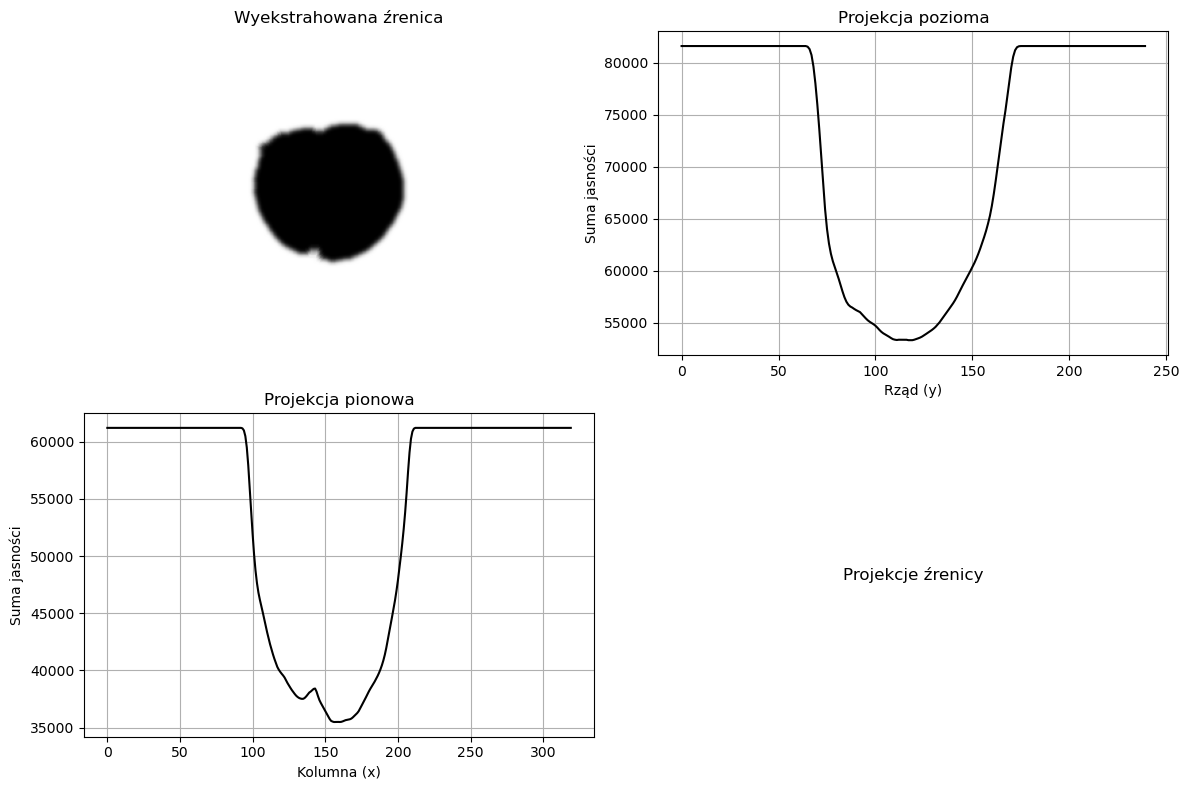

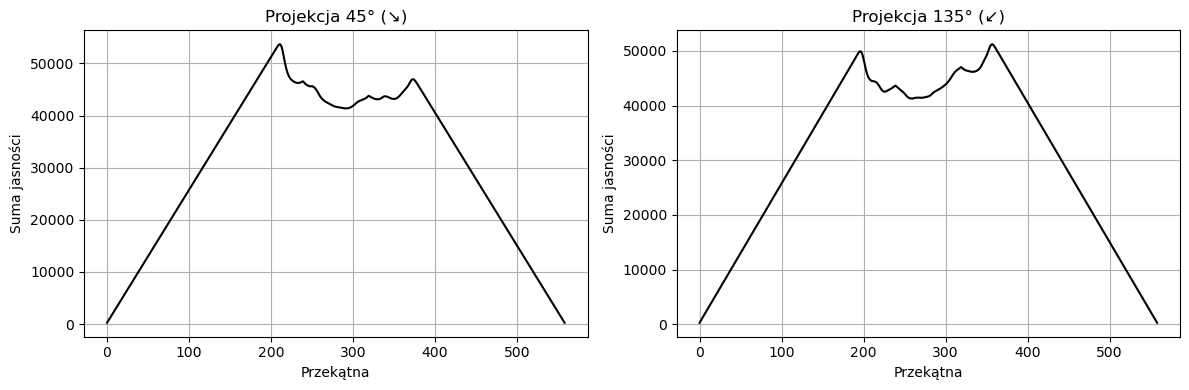

In [13]:
h_proj_iris, v_proj_iris = do_projections(extracted_image, show_plots=True)
d45_proj, d135_proj = do_iris_projections_diagonal(img_iris_extracted)
#x_iris, y_iris, r_iris = find_iris_center_and_radius_from_projections(h_proj_iris, v_proj_iris, d45_proj, d135_proj, diff_threshold=0.5)
x_iris, y_iris, r_iris = find_pupil_center_and_radius_from_projections(h_proj_iris, v_proj_iris, diff_threshold=0.3)

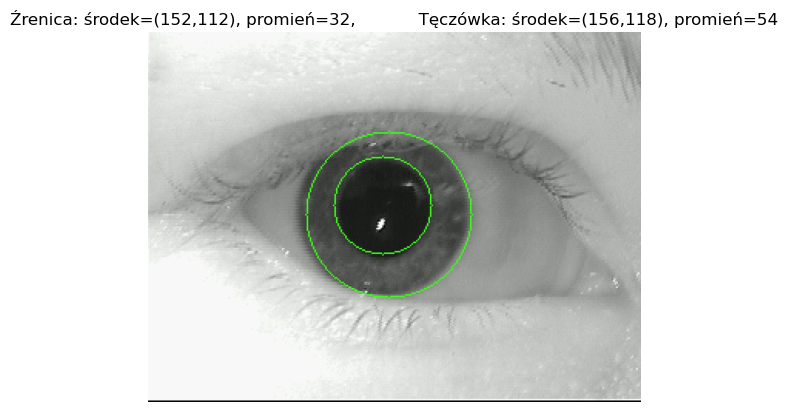

In [14]:
contour_img = draw_contour(original_img, x_pupil, y_pupil, r_pupil)
contour_img = draw_contour(contour_img, x_iris, y_iris, r_iris)
show_image(contour_img, f'Źrenica: środek=({x_pupil},{y_pupil}), promień={r_pupil}, \
           Tęczówka: środek=({x_iris},{y_iris}), promień={r_iris}')